In [ ]:
!pip install -U pip wheel setuptools
!pip install concrete-ml

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [27]:
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score
from concrete.ml.sklearn import LogisticRegression, LinearRegression
from sklearn.linear_model import LogisticRegression as skLR
from sklearn.linear_model import LinearRegression as skLinear
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import pandas as pd

start_time = time.time()
def feature_selection(x, opt = "", var_percent = 0.8, n_features = 30):
    if opt == "var":
        print("\nUsing variance threshold feature selection...")
        # Remove all features that have low variance in more than (percent)% of the samples.
        sel = VarianceThreshold(threshold=(var_percent * (1 - var_percent)))
        print("Shape of X: ", x.shape)
        x = sel.fit_transform(x)
        print("After feature selection: ", len(x[0]), " features")
        cols_idxs = sel.get_support(indices=True)
    elif opt == "kbest":
        print("\nUsing K best features feature selection...")
        print("Shape of x before selection: ", x.shape)
        sel = SelectKBest(chi2, k=n_features)
        x = sel.fit_transform(x, y)
        print("Shape of x after selection: ", x.shape)
        cols_idxs = sel.get_support(indices=True)
    elif opt == "pca":
        print("\nUsing PCA feature selection...")
        x_scaled = StandardScaler().fit_transform(x)
        pca = PCA(n_components=n_features)
        pca_features = pca.fit_transform(x_scaled)
        print('Shape before PCA: ', x_scaled.shape)
        print('Shape after PCA: ', pca_features.shape)
        x = pca_features
        cols_idxs = pca.get_support(indices=True)
    else:
        print("")
    return x, cols_idxs

#select set option
set = -1

dataset = pd.read_csv("DATASET (06-16-2023) Downsized and Includes Omicron Subvariants.csv")

#print(dataset['Lineage'].value_counts())

#remove "EPI_ISL_" from ID
#new_ID_col = []
#for i in range(0, len(dataset['Accession ID'])):
#    new_ID_col.append(str(dataset['Accession ID'].loc[i].replace("EPI_ISL_", "")))
#dataset['Accession ID'] = new_ID_col

feature_cols = [c for c in dataset.columns[2:]]
#print(feature_cols)

x = dataset.loc[:,feature_cols].values #must be floats
y = dataset.loc[:,'Lineage'].values #must be integers

#print(x)
#print(y)

# Preprocessing with labels for the lineage
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)

x = x.astype(float)

print("Shape of x: ", x.shape)
print("Shape of y:", y.shape)

print(f"Running time is {time.time() - start_time} seconds")

['B.1.1.529' 'B.1.617.2' 'B.1.621' 'BA.1' 'BA.1.1' 'BA.1.17.2' 'BA.2'
 'C.37']
Shape of x:  (4007, 512)
Shape of y: (4007,)
Running time is 0.17460203170776367 seconds


In [28]:
print(dataset['Lineage'].value_counts())
print(f"Total: {dataset['Lineage'].count()}")

Lineage
BA.1         572
C.37         552
B.1.617.2    521
BA.2         515
B.1.621      514
B.1.1.529    497
BA.1.1       435
BA.1.17.2    401
Name: count, dtype: int64
Total: 4007


In [29]:
# Feature Selection Cell (ensemble attempted)

start_time = time.time()
#x = feature_selection(x, "var", var_percent = 0.80)
x, cols_idxs = feature_selection(x, "kbest", n_features = 15)
#x = feature_selection(x, "pca", n_features = 5)

# print(dataset.iloc[:,cols_idxs])

print("\nSelected features: ")
for col in cols_idxs:
    print(feature_cols[col])

print(f"Running time is {time.time() - start_time} seconds")


Using K best features feature selection...
Shape of x before selection:  (4007, 512)
Shape of x after selection:  (4007, 15)

Selected features: 
feature_24
feature_32
feature_65
feature_73
feature_76
feature_87
feature_126
feature_140
feature_180
feature_195
feature_209
feature_324
feature_327
feature_407
feature_413
Running time is 0.024805068969726562 seconds


In [30]:
# Retrieve train and test sets

def split(x,y):
    X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30)

    return X_train, X_test, y_train, y_test

start_time = time.time()
X_train, X_test, y_train, y_test = split(x,y)

print(f"Test set size: {X_test.shape}")

print(f"Running time is {time.time() - start_time} seconds")
#st_x = StandardScaler()
#X_train = st_x.fit_transform(X_train)
#X_test = st_x.transform(X_test)

Test set size: (1203, 15)
Running time is 0.0008792877197265625 seconds


In [31]:
results = []
print("Getting performance metrics for scikit-learn model (Plaintext)...")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    start_time = time.time()
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    y_pred_sklearn = skmodel.predict(X_test)
    results.append(f"{skmodel.score(X_test,y_test)*100}")

for r in results:
    print(f"{r}")
#print("Accuracy for sklearn: ", skmodel.score(X_test,y_test)*100,"%")
#print(f"Running time is {time.time() - start_time} seconds")

quantized_results = []
print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)

    start_time = time.time()
    # Run the predictions on non-encrypted data as a reference
    y_pred_clear = model.predict(X_test)

    quantized_results.append(f"{model.score(X_test,y_test) * 100}")
    # print("Accuracy rate for quantized plaintext:  ", model.score(X_test,y_test) * 100, "%")
    # print(f"Running time is {time.time() - start_time} seconds")

for r in quantized_results:
    print(f"{r}")

fhe_results = []
print("Getting performance metrics for Concrete-ML model (FHE)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    #Fit the model
    model.fit(X_train, y_train)
    #print("Compiling...")
    model.compile(x)
    #print("model compiled!")
    y_pred_fhe = model.predict(X_test, fhe="execute")
    fhe_results.append(f"{accuracy_score(y_test, y_pred_fhe) * 100}%")

for r in fhe_results:
    print(f"{r}")

Getting performance metrics for scikit-learn model (Plaintext)...
78.63674147963424
75.81047381546135
76.72485453034082
76.64172901080632
77.3067331670823
79.30174563591022
78.47049044056526
76.14297589359933
77.47298420615128
78.63674147963424
Getting performance metrics for Concrete-ML model (Quantized Plaintext)...
74.3142144638404
78.05486284289277
77.47298420615128
78.38736492103075
77.47298420615128
76.55860349127181
77.38985868661679
77.80548628428927
76.72485453034082
77.97173732335827
Getting performance metrics for Concrete-ML model (FHE)...
78.22111388196176%
76.9742310889443%
77.0573566084788%
79.13549459684123%
77.63923524522028%
76.89110556940982%
75.22859517871987%
76.89110556940982%
78.38736492103075%
77.97173732335827%


In [5]:
# Get running time for training of models
print("Getting training time and number of iterations for scikit-learn model (Plaintext)...")
results = []

for i in range(0,10):
    start_time = time.time()
    X_train, X_test, y_train, y_test = split(x,y)
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    results.append(f"{time.time() - start_time}")

for r in results:
    print(f"{r}")

print("Getting training time and number of iterations for Concrete-ML model (Quantized Plaintext and FHE)...")
quantized_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    start_time = time.time()
    model.fit(X_train, y_train)
    quantized_results.append(f"{time.time() - start_time}")

for r in quantized_results:
    print(f"{r}")

Getting training time and number of iterations for scikit-learn model (Plaintext)...
0.06247591972351074
0.049529314041137695
0.049454450607299805
0.05459284782409668
0.04990673065185547
0.04826641082763672
0.046796321868896484
0.046716928482055664
0.048148393630981445
0.05108904838562012
Getting training time and number of iterations for Concrete-ML model (Quantized Plaintext and FHE)...
0.10984063148498535
0.08402156829833984
0.08368849754333496
0.0739293098449707
0.07214856147766113
0.09466099739074707
0.09340977668762207
0.07601070404052734
0.07851171493530273
0.08089447021484375


In [6]:
print("Getting running time for scikit-learn model (Plaintext)...")
results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    start_time = time.time()
    y_pred_sklearn = skmodel.predict(X_test)
    results.append(f"{time.time() - start_time}")

for r in results:
    print(f"{r}")

print("Getting running time for Concrete-ML model (Quantized Plaintext)...")
quantized_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    model.fit(X_train, y_train)
    start_time = time.time()
    y_pred_clear = model.predict(X_test)
    quantized_results.append(f"{time.time() - start_time}")

for r in quantized_results:
    print(f"{r}")

print("Getting running time for Concrete-ML model (FHE)...")
fhe_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    model.fit(X_train, y_train)
    model.compile(x)
    start_time = time.time()
    y_pred_clear = model.predict(X_test)
    fhe_results.append(f"{time.time() - start_time}")

for r in fhe_results:
    print(f"{r}")

Getting running time for scikit-learn model (Plaintext)...
0.00017690658569335938
0.00017595291137695312
0.0002551078796386719
0.00019693374633789062
0.0002613067626953125
0.00019407272338867188
0.0002617835998535156
0.00021791458129882812
0.0002295970916748047
0.00020360946655273438
Getting running time for Concrete-ML model (Quantized Plaintext)...
0.0003635883331298828
0.0004222393035888672
0.0005109310150146484
0.0003960132598876953
0.0003819465637207031
0.0007658004760742188
0.0006692409515380859
0.0006051063537597656
0.0006952285766601562
0.0004951953887939453
Getting running time for Concrete-ML model (FHE)...
0.0018923282623291016
0.0012898445129394531
0.0010807514190673828
0.00064849853515625
0.0005714893341064453
0.002024412155151367
0.0005273818969726562
0.0007891654968261719
0.0006153583526611328
0.0005872249603271484


In [ ]:
# # Initialize model and fix the number of bits to used for quantization 

# model = LogisticRegression(C=1)

# # Fit the model
# model.fit(X_train, y_train)

# start_time = time.time()
# # Run the predictions on non-encrypted data as a reference
# y_pred_clear = model.predict(X_test)

# # Output (plaintext vs FHE):
# # print("In clear:  ", le.inverse_transform(y_pred_clear))
# # accuracy_score(y_test, y_pred_clear)
# print("Accuracy rate for quantized plaintext:  ", model.score(X_test,y_test) * 100, "%")
# print(f"Running time is {time.time() - start_time} seconds")

# #low/higly volatile accuracy may be attributed to small dataset and too many features 
# #(feature selection needed and more samples are required)
# print("PREDICTION:\n", y_pred_clear)
# print("ACTUAL:\n", y_test) 

# # Compile into a FHE model
# start_time = time.time()
# print("Compiling...")
# model.compile(x)
# print("model compiled!")
# print(f"Running time is {time.time() - start_time} seconds")

# # Run the inference in FHE
# start_time = time.time()
# print("Predicting in FHE...")
# y_pred_fhe = model.predict(X_test, fhe="execute")
# print("Accuracy rate for FHE:  ", accuracy_score(y_test, y_pred_fhe) * 100, "%")

# #print("In FHE    :", y_pred_fhe)
# print(f"Comparison: {int((y_pred_fhe == y_pred_clear).sum()/len(y_pred_fhe)*100)}% similar")
# print(f"Running time is {time.time() - start_time} seconds")

In [32]:
#Get AUC for multiclass
#NOTE WE HAVE A MULTICLASS BUT NOT MULTILABEL PROBLEM. only one label selected from multiple classes is assigned
start_time = time.time()
results = []
quantized_results = []
fhe_results = []

print("Getting performance metrics for scikit-learn model (Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    #start_time = time.time()
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    results.append(roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovr'))

for r in results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)
    quantized_results.append(roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))

for r in quantized_results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (FHE)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)
    #print("Compiling...")
    model.compile(x)
    fhe_results.append(roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))

for r in fhe_results:
    print(f"{r}")

#print("Scikit learn ROC AUC Score (One vs Rest): ", roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovr'))
#print("Scikit learn AUROC (One vs One): ", roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovo'))
#print("Macro-averaged Concrete-ML ROC AUC Score (One vs Rest): ", roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))
#print("Concrete-ML AUROC (One vs One): ", roc_auc_score(y, model.predict_proba(x), multi_class='ovo'))
#print(f"Running time is {time.time() - start_time} seconds")

Getting performance metrics for scikit-learn model (Plaintext)...
0.9584467097844153
0.9584562289624967
0.9579356081651919
0.9586165442842998
0.9582596588471739
0.9586204806871177
0.9580359370972715
0.9586978960078061
0.9586544404402388
0.9582008539396318
Getting performance metrics for Concrete-ML model (Quantized Plaintext)...
0.9580559394664758
0.9581459284946473
0.9581641104535963
0.9585049418370075
0.9584717172271452
0.9582149606659711
0.9575024585825389
0.9578913145020553
0.9582269362033454
0.9577629482385581
Getting performance metrics for Concrete-ML model (FHE)...
0.9582912519028858
0.9585008637544739
0.9582235403976596
0.9581294075791054
0.9584056625094519
0.9586651835892896
0.9583876308903094
0.9581697294205125
0.9582395593519947
0.9581471002342015


***Note: The diagonal elements are the correctly predicted samples. ***
Confusion matrix for SKLearn Plaintext: 


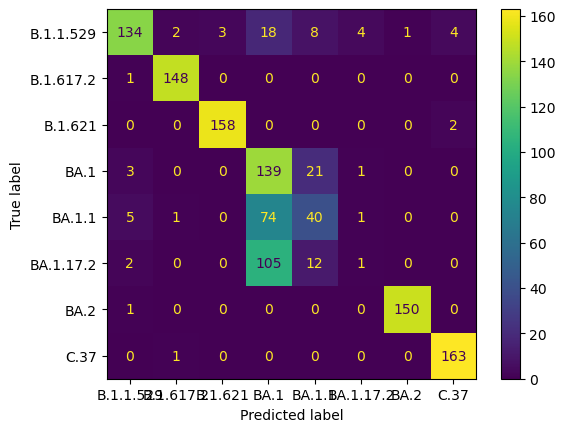

Confusion matrix for Quantized Plaintext: 


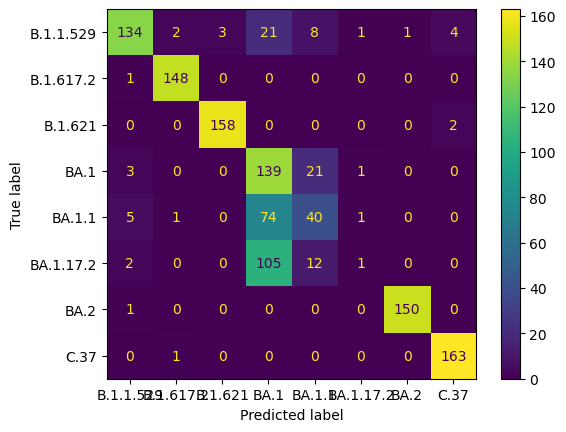

Confusion matrix for FHE: 


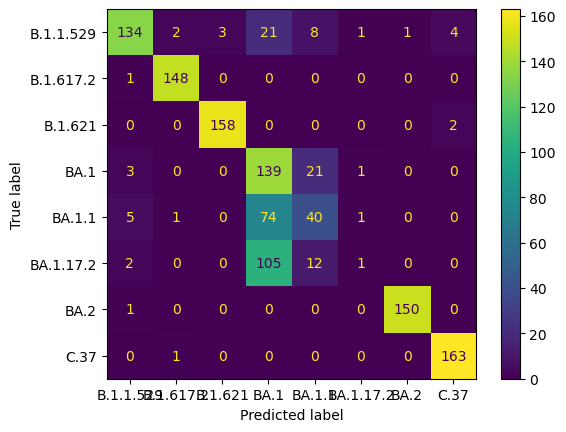

Running time is 2.067664861679077 seconds
Comparison (FHE vs Plaintext): 99% similar
Comparison (FHE vs Quantized Plaintext): 100% similar


In [34]:
# In[10]:
start_time = time.time()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("***Note: The diagonal elements are the correctly predicted samples. ***")

#use the scikit-learn classes because we use the same class naman
X_train, X_test, y_train, y_test = split(x,y)

print("Confusion matrix for SKLearn Plaintext: ")
#print(confusion_matrix(y_test, y_pred_sklearn), "\n")
skmodel = skLR(C=1)
skmodel.fit(X_train,y_train)
y_pred_sklearn = skmodel.predict(X_test)
sklearn_cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_sklearn), display_labels=le.classes_)
sklearn_cm_display.plot()
plt.show()

print("Confusion matrix for Quantized Plaintext: ")
#print(confusion_matrix(y_test, y_pred_clear), "\n")
model = LogisticRegression(C=1)
model.fit(X_train,y_train)
y_pred_clear = model.predict(X_test)
concrete_plain_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_clear), display_labels=le.classes_)
concrete_plain_display.plot()
plt.show()

print("Confusion matrix for FHE: ")
#print(confusion_matrix(y_test, y_pred_fhe))
model.compile(x)
y_pred_fhe = model.predict(X_test)
concrete_fhe_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_fhe), display_labels=le.classes_)
concrete_fhe_display.plot()
plt.show()

print(f"Running time is {time.time() - start_time} seconds")

print(f"Comparison (FHE vs Plaintext): {int((y_pred_fhe == y_pred_sklearn).sum()/len(y_pred_fhe)*100)}% similar")
print(f"Comparison (FHE vs Quantized Plaintext): {int((y_pred_fhe == y_pred_clear).sum()/len(y_pred_fhe)*100)}% similar")

In [35]:
from concrete.ml.sklearn.svm import LinearSVC
from sklearn.svm import LinearSVC as skSVC
from concrete.ml.sklearn.rf import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as skRF

print(f"Sklearn Accuracy (Linear Reg, RF, SVC):")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)

    #SKLEARN LINEAR REGRESSION
    skmodel2 = skLinear()
    skmodel2.fit(X_train,y_train)
    skmodel2.predict(X_test)
    #print("Sklearn Linear Regression Accuracy: ", skmodel2.score(X_test,y_test)*100,"%")

    #SKLEARN RANDOM FOREST
    skmodel3 = skRF()
    skmodel3.fit(X_train, y_train)
    skmodel3.predict(X_test)
    #print("Sklearn Random Forest Accuracy: ",skmodel3.score(X_test,y_test)*100,"%")

    #SKLEARN SVC
    skmodel4 = skSVC()
    skmodel4.fit(X_train, y_train)
    skmodel4.predict(X_test)
    #print("Sklearn SVC Accuracy: ",skmodel4.score(X_test,y_test)*100,"%")

    print(f"{skmodel2.score(X_test,y_test)*100} {skmodel3.score(X_test,y_test)*100} {skmodel4.score(X_test,y_test)*100}")

print(f"Concrete-ML Accuracy (Linear Reg, RF, SVC):")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model2 = LinearRegression()
    model2.fit(X_train,y_train)
    model2.predict(X_test)
    print("Concrete-ML Linear Regression Accuracy: ", model2.score(X_test,y_test)*100,"%")

    model3 = RandomForestClassifier()
    model3.fit(X_train, y_train)
    model3.predict(X_test)
    print("Concrete-ML Random Forest Accuracy: ",model3.score(X_test,y_test)*100,"%")

    model4 = LinearSVC()
    model4.fit(X_train, y_train)
    model4.predict(X_test)
    print("Concrete-ML SVC Accuracy: ",model4.score(X_test,y_test)*100,"%")

    print(f"{model2.score(X_test,y_test)*100}   {model3.score(X_test,y_test)*100}   {model4.score(X_test,y_test)*100}")

Sklearn Accuracy (Linear Reg, RF, SVC):
70.48026180738457 78.80299251870323 76.80798004987531
71.88732434618291 79.05236907730672 71.73732335827098
65.59692454464839 77.97173732335827 75.06234413965088
71.23947746943406 77.38985868661679 76.9742310889443
68.5731300334552 76.72485453034082 74.72984206151288
71.40035314126476 79.80049875311721 75.64422277639235
69.67463859890526 77.72236076475478 72.31920199501248
69.98555631913497 79.46799667497922 77.0573566084788
66.86479729624463 77.88861180382376 72.23607647547797
68.58969599284646 78.55361596009975 72.31920199501248
Concrete-ML Accuracy (Linear Reg, RF, SVC):
68.11913010799253   74.56359102244389   74.72984206151288
70.95492676907377   76.22610141313383   77.47298420615128
70.59439828413606   74.81296758104739   76.64172901080632
70.25633659952233   75.64422277639235   74.97921862011637
68.92246598703441   74.3142144638404   72.90108063175394
69.42894986618154   76.05985037406484   78.38736492103075
65.01484458817168   73.482959268

In [ ]:
# In[10]:


#Attempting to save the model
from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer

start_time = time.time()

fhemodel_dev = FHEModelDev("./concrete-covid-classifier", model)
fhemodel_dev.save()

print(f"Running time for saving the FHE model is {time.time() - start_time} seconds")

In [ ]:
#Saving Scikit-learn model
from joblib import dump, load

dump(skmodel, './scikit-learn-classifier/scikitlearnmodel.joblib')
#loaded_model = load('scikitlearnmodel.joblib')